In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve

# be careful with that:
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_heatmap = pd.read_csv('A_data_heatmap_300x250_3p.csv')
data_heatmap

,Unnamed: 0,domain,grid_id,click_x,click_y,display_height,display_width,clicks
0,0,ID_1763,333519,179,4,250,300,1
1,1,ID_1763,333519,262,185,250,300,1
2,2,ID_1763,333519,122,188,250,300,1
3,3,ID_1763,333519,263,197,250,300,1
4,4,ID_1763,333519,242,159,250,300,1
...,...,...,...,...,...,...,...,...
1935421,1935421,ID_1501,333519,163,145,250,300,8
1935422,1935422,ID_1501,333519,41,139,250,300,4
1935423,1935423,ID_1501,333519,213,97,250,300,2
1935424,1935424,ID_1501,333519,271,245,250,300,1


In [3]:
# expand so that each row corresponds to 1 click:
data_heatmap_expanded = data_heatmap.loc[data_heatmap.index.repeat(data_heatmap['clicks'])].reset_index(drop=True)
data_heatmap_expanded['clicks'] = 1

In [4]:
# Binning clicks in nr_of_x_bins, nr_of_y_bins:
NR_OF_X_BINS = 61 # number of bins
NR_OF_Y_BINS = 51

max_width = data_heatmap_expanded['display_width'].max() #300
max_height = data_heatmap_expanded['display_height'].max() #250

width_bins = np.linspace(1, max_width, NR_OF_X_BINS)
height_bins = np.linspace(1, max_height, NR_OF_Y_BINS)

width_bins_max = len(width_bins)-2 # start at 0
height_bins_max = len(height_bins)-2

# bin nearby x clicks together
data_heatmap_expanded['click_x_bin'] = pd.cut(data_heatmap_expanded['click_x'], bins = width_bins, labels=False, include_lowest=True)
data_heatmap_expanded['click_y_bin'] = pd.cut(data_heatmap_expanded['click_y'], bins=height_bins, labels=False, include_lowest=True)

In [75]:
# grid_id = 333519/333346
aggregated_clicks = data_heatmap_expanded.groupby(['grid_id', 'domain', 'click_x_bin', 'click_y_bin'])['clicks'].sum().reset_index(name='clicks_sum')
aggregated_clicks = aggregated_clicks[aggregated_clicks['grid_id'] == 333346]
# aggregated_clicks = aggregated_clicks[aggregated_clicks['grid_id'] == 333519]
pivot_df = pd.pivot_table(aggregated_clicks, values='clicks_sum', index=['domain', 'grid_id'],
                           columns=['click_x_bin', 'click_y_bin'], aggfunc='sum', fill_value=0)
pivot_df.reset_index(inplace=True)
pivot_df.columns = ['domain', 'grid_id'] + [f'clicks_sum_for_{x}_{y}' for x, y in pivot_df.columns[2:]]
pivot_df

,domain,grid_id,clicks_sum_for_0_0,clicks_sum_for_0_1,clicks_sum_for_0_2,clicks_sum_for_0_3,clicks_sum_for_0_4,clicks_sum_for_0_5,clicks_sum_for_0_6,clicks_sum_for_0_7,...,clicks_sum_for_59_40,clicks_sum_for_59_41,clicks_sum_for_59_42,clicks_sum_for_59_43,clicks_sum_for_59_44,clicks_sum_for_59_45,clicks_sum_for_59_46,clicks_sum_for_59_47,clicks_sum_for_59_48,clicks_sum_for_59_49
0,ID_1,333346,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ID_10,333346,54,36,12,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,ID_1002,333346,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ID_1005,333346,0,0,0,0,4,0,1,0,...,1,0,0,0,0,1,0,0,2,0
4,ID_1010,333346,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,ID_978,333346,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
857,ID_989,333346,0,1,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
858,ID_993,333346,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
859,ID_996,333346,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [43]:
# anomaly detection
features = pivot_df.iloc[:,2:]

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Fit K-means model
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(scaled_features)

# Assign cluster labels to the original DataFrame
pivot_df['cluster'] = kmeans.labels_

# Identify the smallest cluster or the one furthest from others
cluster_sizes = pivot_df['cluster'].value_counts()
smallest_cluster_label = cluster_sizes.idxmin()

# Anomalies are the points in the smallest or most distant cluster
anomalies = pivot_df[pivot_df['cluster'] == smallest_cluster_label]

# Sort anomalies based on some criterion, e.g., distance from cluster centroid
centroids = kmeans.cluster_centers_
anomalies['distance_from_centroid'] = anomalies.apply(
    lambda row: np.linalg.norm(centroids[row['cluster']] - scaler.transform([row[features.columns]])),
    axis=1
)
anomalies_sorted = anomalies.sort_values(by='distance_from_centroid', ascending=False)

# Now investigate the sorted anomalies
print(anomalies_sorted[['domain', 'distance_from_centroid']])

      domain  distance_from_centroid
126  ID_1501                     0.0


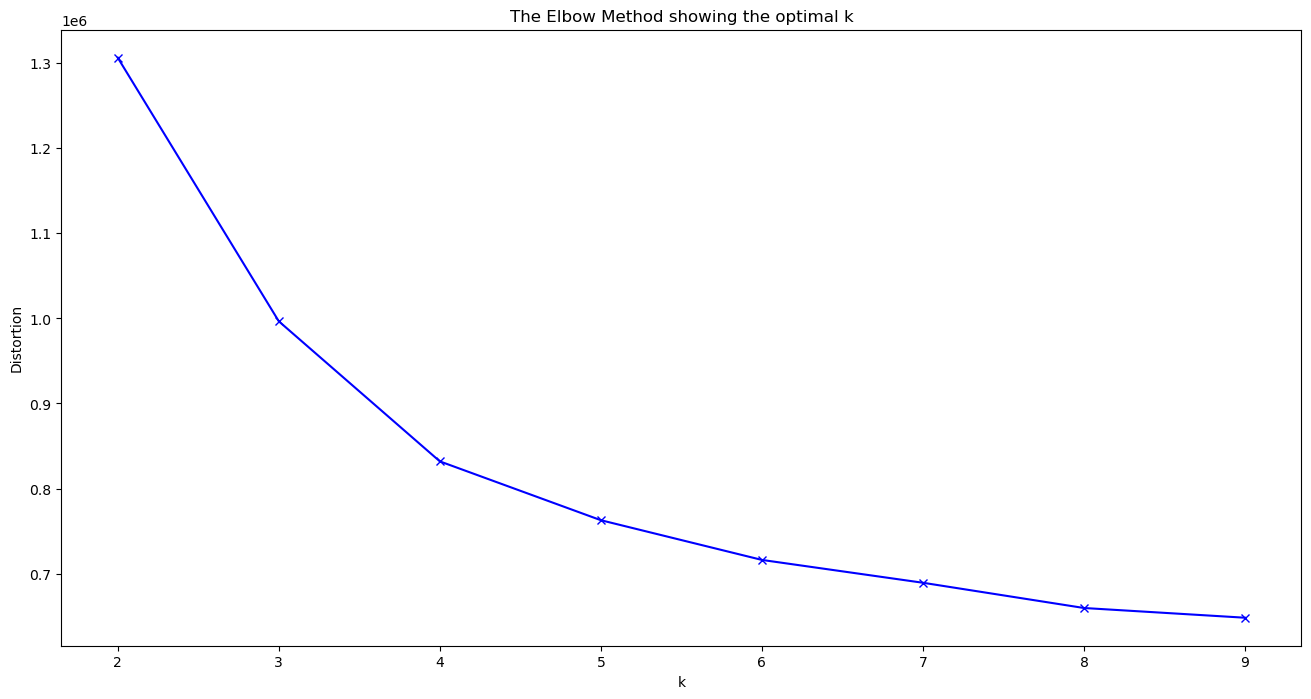

In [44]:
# hyperparameter tuning
distortions = []
K = range(2, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(scaled_features)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow occurs when k=4 or k=5, which means the within-cluster sum of squares starts to decrease more slowly. We will use stick to k=5 here.

In [45]:
broken_pred = anomalies_sorted.domain.unique()
len(broken_pred)

1

In [46]:
def plot_anomaly(n_rows, n_cols, anomaly, grid_id):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))  # Adjust the figure size as needed
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between plots

    plot_count = 0

    for domain in anomaly:
        ex = aggregated_clicks[(aggregated_clicks.grid_id == grid_id) &
                            (aggregated_clicks.domain == domain)]
        if len(ex) == 0: # skips the entries that are not in heatmap data 
            continue

        click_matrix = ex.pivot("click_y_bin", "click_x_bin", "clicks_sum").fillna(0)
        
        if plot_count == n_rows * n_cols:  # Check if the figure is full
            #plt.savefig(f'heatmap_combined_{idx}.png', bbox_inches='tight')  # Save current figure
            plt.show()
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))  # Start a new figure
            fig.subplots_adjust(hspace=0.4, wspace=0.4)
            plot_count = 0  # Reset plot count for the new figure

        row = plot_count // n_cols
        col = plot_count % n_cols
        
        ax = axes[row, col]
        sns.heatmap(click_matrix, 
                    cmap="YlGnBu", 
                    annot=False, 
                    cbar=True, 
                    fmt="g", 
                    ax=ax)
        ax.set_title(f'Click Heatmap for grid = {grid_id} and domain = {domain}')
        ax.set_xlabel('click_x Bin')
        ax.set_ylabel('click_y Bin')
        ax.invert_yaxis()
        
        plot_count += 1

    if plot_count > 0:
    #    plt.savefig(f'heatmap_combined_final.png', bbox_inches='tight')
        plt.show()

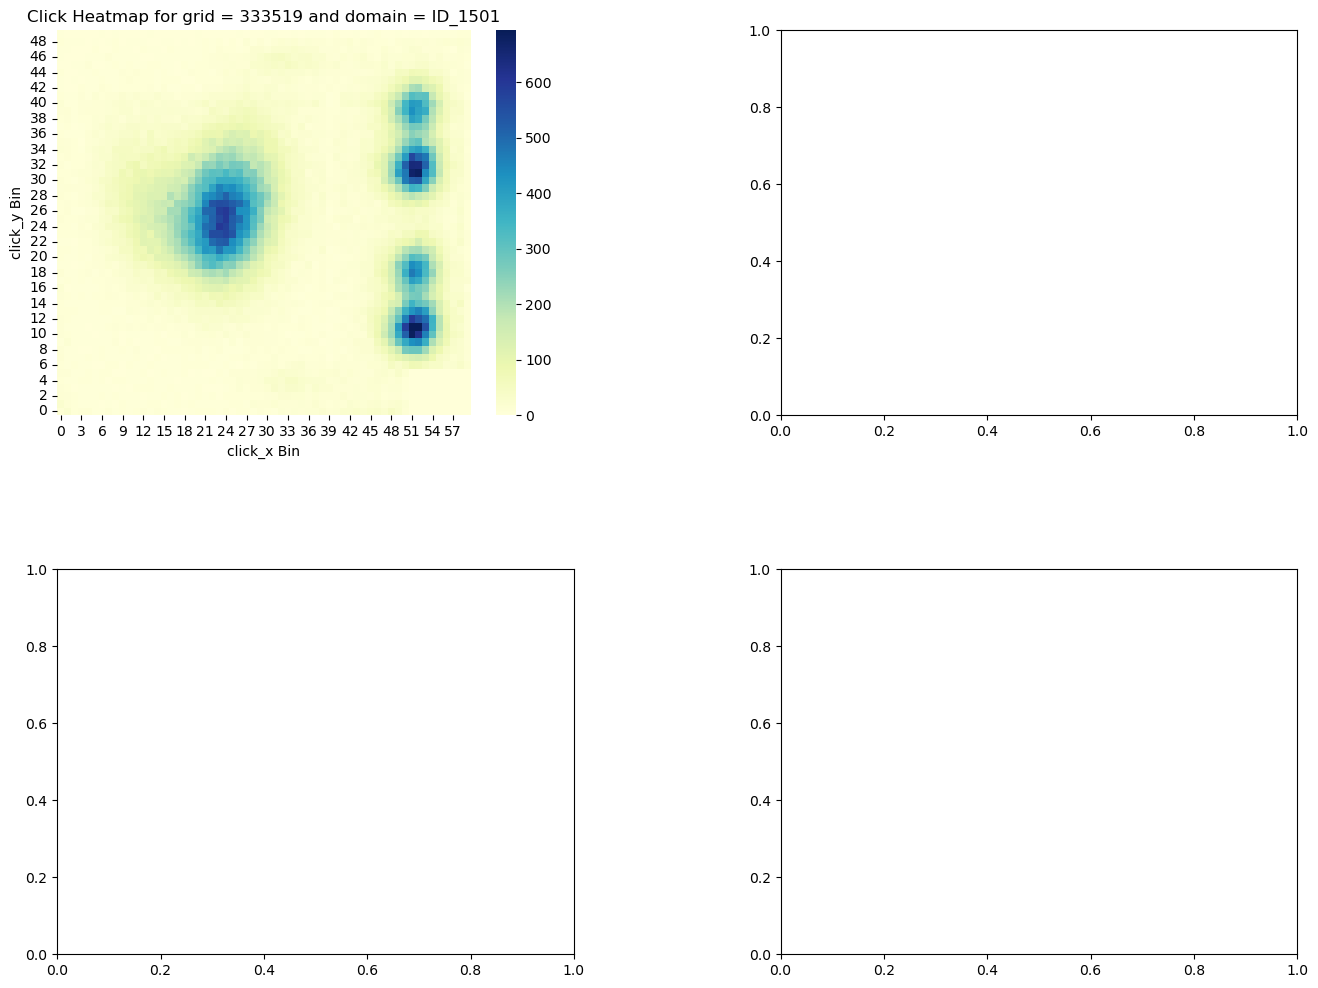

In [54]:
# visualize some of the predicted broken heatmaps
plot_anomaly(2,2,broken_pred,333519)

In [7]:
clealy_broken_333519 = ['ID_1184', 'ID_1281', 'ID_1305', 'ID_1353', 'ID_1448', 'ID_1522',
       'ID_1544', 'ID_162', 'ID_1682', 'ID_1690', 'ID_1824', 'ID_1888',
       'ID_1929', 'ID_2076', 'ID_2097', 'ID_2226', 'ID_2249', 'ID_2268',
       'ID_2331', 'ID_2339', 'ID_2386', 'ID_2396', 'ID_2438', 'ID_258',
       'ID_2609', 'ID_2680', 'ID_2863', 'ID_2883', 'ID_2908', 'ID_3061',
       'ID_3243', 'ID_3250', 'ID_3314', 'ID_3382', 'ID_3397', 'ID_3402',
       'ID_3420', 'ID_3459', 'ID_3470', 'ID_3540', 'ID_398', 'ID_409',
       'ID_484', 'ID_489', 'ID_526', 'ID_549', 'ID_580', 'ID_665',
       'ID_810', 'ID_84', 'ID_857', 'ID_86', 'ID_905', 'ID_927', 'ID_934',
       'ID_962', 'ID_986']
overlap = set(broken_pred) & set(clealy_broken_333519)
percent = len(overlap)/len(clealy_broken_333519)*100
print(f'Percentage of k-means overlap within the already identified broken domains: {percent:.2f}%')
percent = len(overlap)/len(broken_pred)*100
print(f'Percentage of already identified broken domains within k-means predicted broken ones: {percent:.2f}%')

NameError: name 'broken_pred' is not defined

## PCA & train_test_split

In [76]:
clealy_broken_333519 = ['ID_1184', 'ID_1281', 'ID_1305', 'ID_1353', 'ID_1448', 'ID_1522',
       'ID_1544', 'ID_162', 'ID_1682', 'ID_1690', 'ID_1824', 'ID_1888',
       'ID_1929', 'ID_2076', 'ID_2097', 'ID_2226', 'ID_2249', 'ID_2268',
       'ID_2331', 'ID_2339', 'ID_2386', 'ID_2396', 'ID_2438', 'ID_258',
       'ID_2609', 'ID_2680', 'ID_2863', 'ID_2883', 'ID_2908', 'ID_3061',
       'ID_3243', 'ID_3250', 'ID_3314', 'ID_3382', 'ID_3397', 'ID_3402',
       'ID_3420', 'ID_3459', 'ID_3470', 'ID_3540', 'ID_398', 'ID_409',
       'ID_484', 'ID_489', 'ID_526', 'ID_549', 'ID_580', 'ID_665',
       'ID_810', 'ID_84', 'ID_857', 'ID_86', 'ID_905', 'ID_927', 'ID_934',
       'ID_962', 'ID_986']
clearly_broken_333346 = ['ID_1247', 'ID_162', 'ID_2534', 'ID_2742', 'ID_526', 'ID_2201',
       'ID_1165', 'ID_743', 'ID_199', 'ID_2145', 'ID_2569', 'ID_643',
       'ID_1305', 'ID_3180', 'ID_3158', 'ID_136', 'ID_293', 'ID_1753',
       'ID_1849', 'ID_2226', 'ID_1462', 'ID_626', 'ID_2863', 'ID_3243',
       'ID_3250', 'ID_1708', 'ID_1238', 'ID_580', 'ID_84', 'ID_2568',
       'ID_2340', 'ID_1803', 'ID_3470', 'ID_139', 'ID_2619', 'ID_2908',
       'ID_1281', 'ID_3308', 'ID_2883', 'ID_1320', 'ID_1333', 'ID_1062',
       'ID_149', 'ID_260', 'ID_599', 'ID_1513', 'ID_3402', 'ID_1888',
       'ID_2972', 'ID_398', 'ID_2339', 'ID_1030', 'ID_3382', 'ID_2076',
       'ID_1646', 'ID_1077', 'ID_10', 'ID_1153', 'ID_1533', 'ID_2609',
       'ID_1214', 'ID_810', 'ID_2097', 'ID_2386', 'ID_1585', 'ID_549',
       'ID_3420', 'ID_3397', 'ID_2006', 'ID_561', 'ID_1542', 'ID_1570',
       'ID_1819', 'ID_1413', 'ID_1240', 'ID_793', 'ID_831', 'ID_3188',
       'ID_1437', 'ID_556', 'ID_1134', 'ID_314', 'ID_2836', 'ID_1483',
       'ID_2676', 'ID_665', 'ID_15', 'ID_2755', 'ID_2194', 'ID_1682',
       'ID_2775', 'ID_1923', 'ID_1846', 'ID_1262', 'ID_3314', 'ID_1448',
       'ID_1770', 'ID_2626', 'ID_3296', 'ID_489', 'ID_1963', 'ID_1268',
       'ID_1568', 'ID_1094', 'ID_2267', 'ID_409', 'ID_1650', 'ID_1522',
       'ID_927', 'ID_2302', 'ID_1929', 'ID_1435', 'ID_1353']
normalized_input = pivot_df.copy()
normalized_input.iloc[:,2:] = (normalized_input.iloc[:,2:].transpose()/normalized_input.iloc[:,2:].sum(axis=1)).transpose()
normalized_input['label'] = 0
normalized_input.loc[normalized_input.domain.isin(clearly_broken_333346),'label'] = 1
# normalized_input.loc[normalized_input.domain.isin(clealy_broken_333519),'label'] = 1
normalized_input

,domain,grid_id,clicks_sum_for_0_0,clicks_sum_for_0_1,clicks_sum_for_0_2,clicks_sum_for_0_3,clicks_sum_for_0_4,clicks_sum_for_0_5,clicks_sum_for_0_6,clicks_sum_for_0_7,...,clicks_sum_for_59_41,clicks_sum_for_59_42,clicks_sum_for_59_43,clicks_sum_for_59_44,clicks_sum_for_59_45,clicks_sum_for_59_46,clicks_sum_for_59_47,clicks_sum_for_59_48,clicks_sum_for_59_49,label
0,ID_1,333346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0
1,ID_10,333346,0.023926,0.015950,0.005317,0.000443,0.000443,0.000000,0.000443,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000,1
2,ID_1002,333346,0.000000,0.000000,0.001733,0.000000,0.000000,0.001733,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0
3,ID_1005,333346,0.000000,0.000000,0.000000,0.000000,0.001278,0.000000,0.000320,0.0,...,0.0,0.0,0.0,0.000000,0.00032,0.0,0.0,0.000639,0.000000,0
4,ID_1010,333346,0.000000,0.000000,0.000000,0.000000,0.000000,0.003236,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.003236,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,ID_978,333346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0
857,ID_989,333346,0.000000,0.001486,0.001486,0.000000,0.001486,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.001486,0.00000,0.0,0.0,0.000000,0.000000,0
858,ID_993,333346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0
859,ID_996,333346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.002959,0.00000,0.0,0.0,0.000000,0.000000,0


In [77]:
X = normalized_input.iloc[:,2:-1]
y = normalized_input.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
# number of components
n_components = 2

# Instantiate the PCA model
pca = PCA(n_components=n_components)

# pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])

# Fit and transform the data
pca_result = pca.fit_transform(X_train)

# Create a DataFrame with the PCA results
train_pca = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])

train_pca['domain'] = normalized_input.iloc[X_train.index, 0].values
train_pca.set_index(X_train.index)
train_pca = train_pca.assign(label=y_train.values)
train_pca

,PC1,PC2,domain,label
0,-0.002938,-0.006612,ID_167,0
1,-0.000099,-0.005538,ID_1559,0
2,0.000989,-0.007065,ID_2132,0
3,-0.003043,-0.006121,ID_1399,0
4,-0.000457,-0.008389,ID_2337,0
...,...,...,...,...
683,-0.002957,-0.006443,ID_1261,0
684,-0.002957,-0.007042,ID_1409,0
685,0.000240,-0.007177,ID_1943,0
686,-0.001545,-0.005059,ID_2608,0


In [79]:
test_result = pca.transform(X_test)
test_pca = pd.DataFrame(data=test_result, columns=[f'PC{i+1}' for i in range(n_components)])

test_pca['domain'] = normalized_input.iloc[X_test.index, 0].values
test_pca.set_index(X_test.index)
test_pca = test_pca.assign(label=y_test.values)
test_pca

,PC1,PC2,domain,label
0,-0.002761,0.005912,ID_409,1
1,-0.002986,-0.002011,ID_3197,0
2,-0.004569,0.121165,ID_1448,1
3,0.001851,-0.006548,ID_1748,0
4,-0.002963,-0.006879,ID_2374,0
...,...,...,...,...
168,-0.003021,-0.006378,ID_1839,0
169,-0.001100,-0.005424,ID_2195,0
170,-0.002544,0.000499,ID_1770,1
171,-0.003068,-0.008034,ID_701,0


In [95]:
# Fit K-means model
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(train_pca.iloc[:,:2])

# Assign cluster labels to the original DataFrame
train_pca['cluster'] = kmeans.labels_

# Identify the smallest cluster or the one furthest from others
cluster_sizes = train_pca['cluster'].value_counts()
cluster_sizes

3    605
0     55
2     19
4      8
1      1
Name: cluster, dtype: int64

In [96]:
broken_cluster = [0,1,2,4] # self identified
pred = kmeans.predict(test_pca.iloc[:,0:2])
test_pca['pred'] = np.isin(pred, broken_cluster).astype(int)
test_pca

,PC1,PC2,domain,label,pred
0,-0.002761,0.005912,ID_409,1,1
1,-0.002986,-0.002011,ID_3197,0,0
2,-0.004569,0.121165,ID_1448,1,1
3,0.001851,-0.006548,ID_1748,0,0
4,-0.002963,-0.006879,ID_2374,0,0
...,...,...,...,...,...
168,-0.003021,-0.006378,ID_1839,0,0
169,-0.001100,-0.005424,ID_2195,0,0
170,-0.002544,0.000499,ID_1770,1,0
171,-0.003068,-0.008034,ID_701,0,0


In [97]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(confusion_matrix(test_pca['label'], test_pca['pred']))
report = classification_report(test_pca['label'], test_pca['pred'])
print(report)

tn, fp, fn, tp = confusion_matrix(test_pca['label'], test_pca['pred']).ravel()

tpr = tp / (tp + fn) *100 if (tp + fn) != 0 else 0 
tnr = tn / (tn + fp) *100 if (tn + fp) != 0 else 0
print(f'True Positive Rate: {tpr:.2f}%  True Negative Rate: {tnr:.2f}%')

[[147   1]
 [  4  21]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       148
           1       0.95      0.84      0.89        25

    accuracy                           0.97       173
   macro avg       0.96      0.92      0.94       173
weighted avg       0.97      0.97      0.97       173

True Positive Rate: 84.00%  True Negative Rate: 99.32%
